In [1]:
%pip install seaborn 
import seaborn as sns
import numpy as np
from seafreeze import seafreeze as sf
import os as os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np


Note: you may need to restart the kernel to use updated packages.


## Read parquet files, create objects to store summary stats 

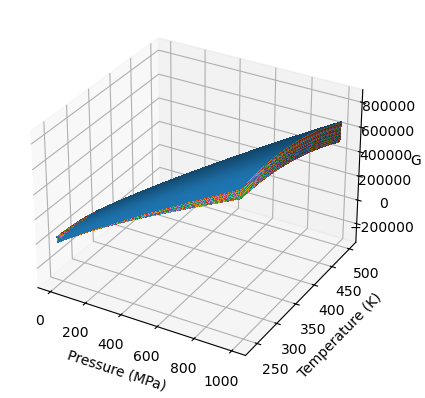

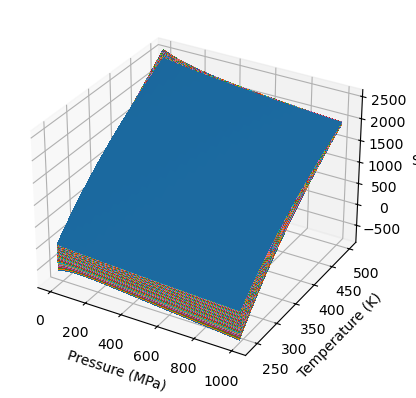

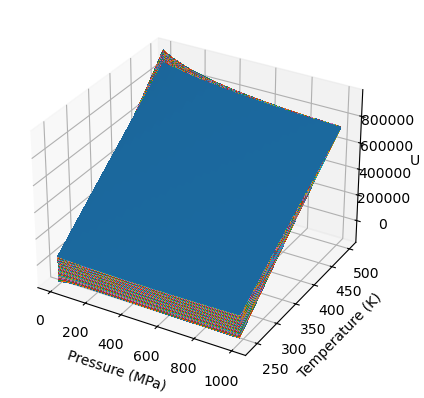

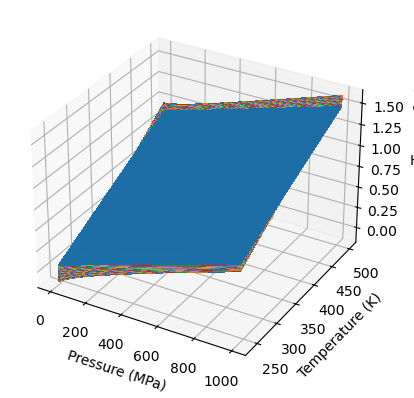

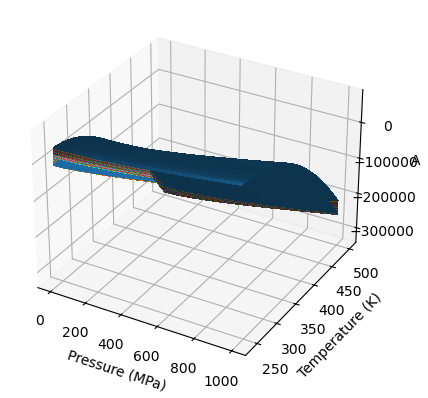

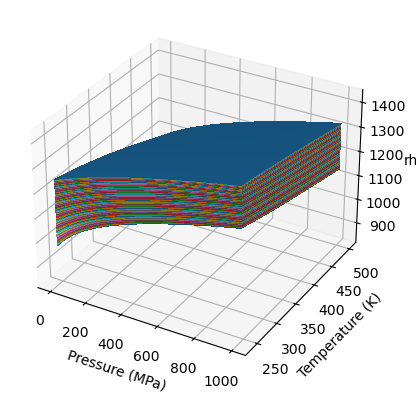

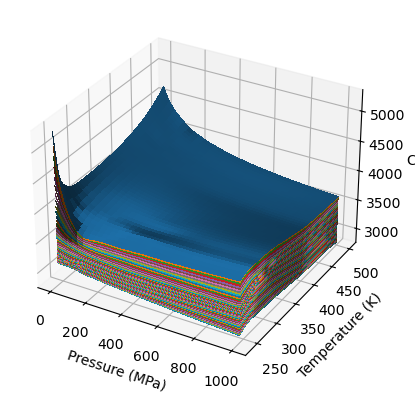

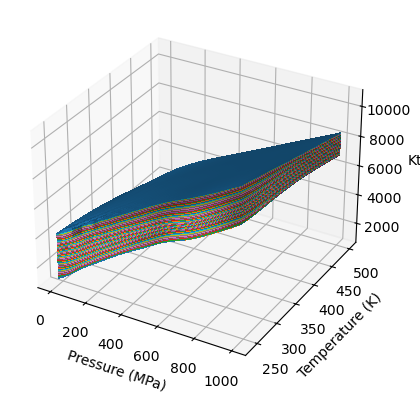

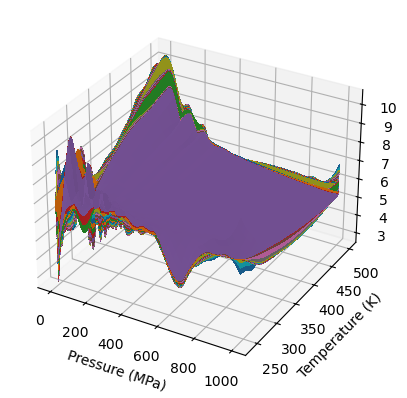

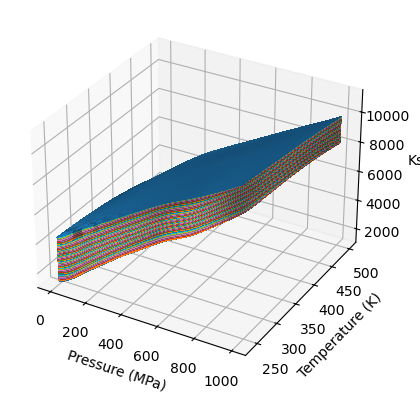

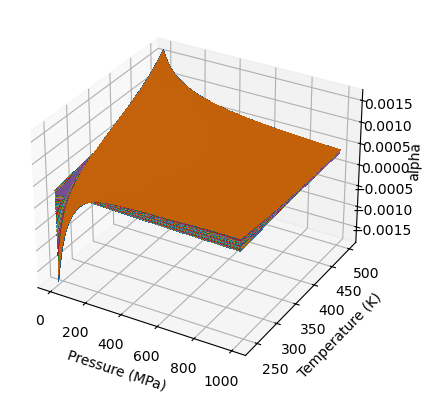

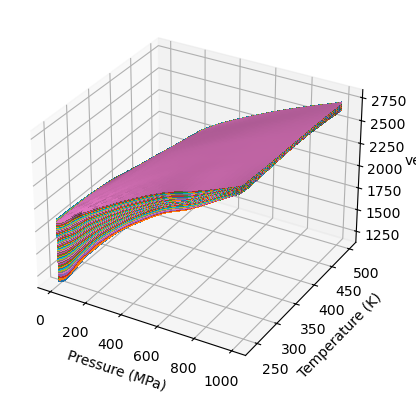

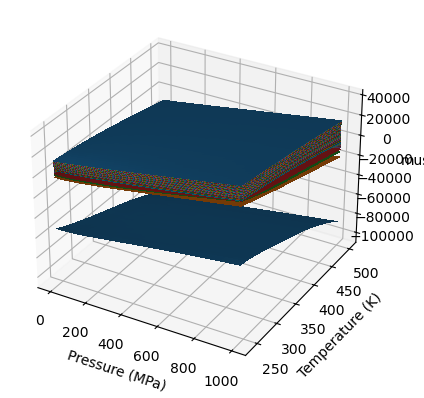

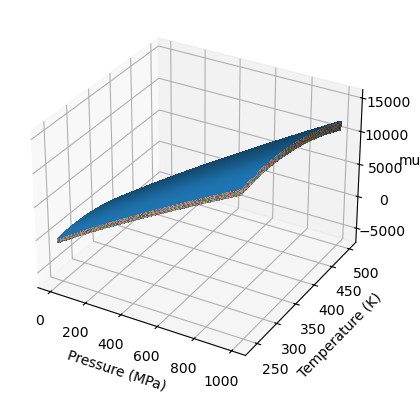

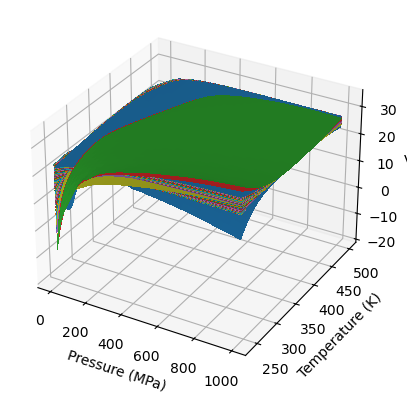

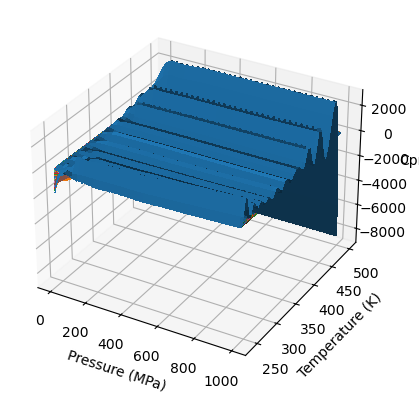

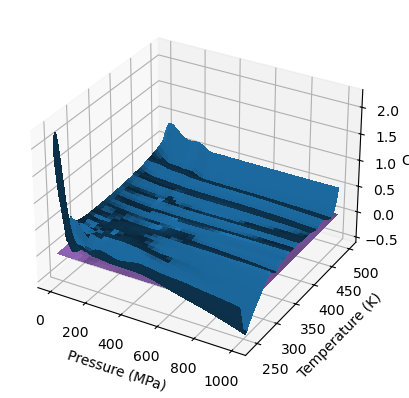

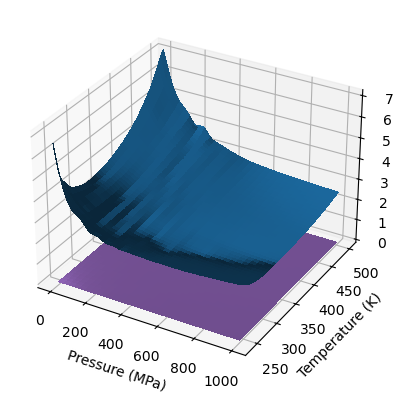

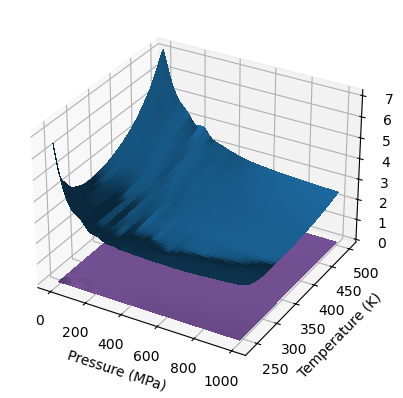

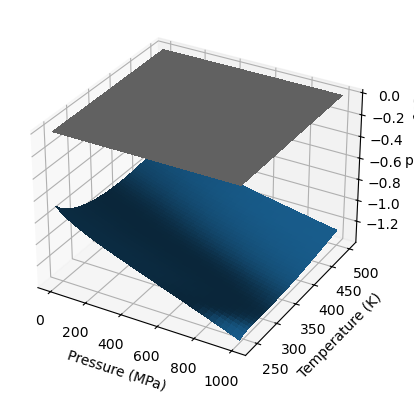

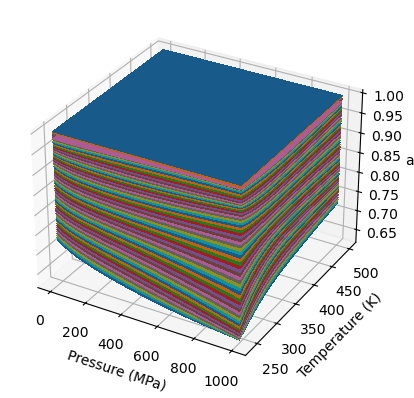

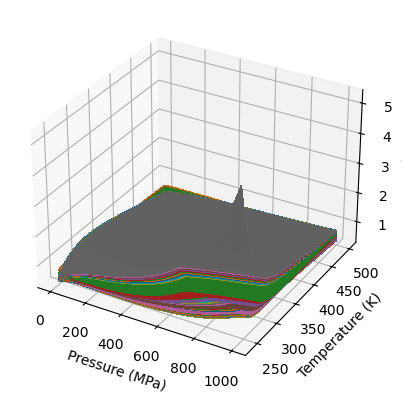

/opt/anaconda3/envs/mlgeo-dataset/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


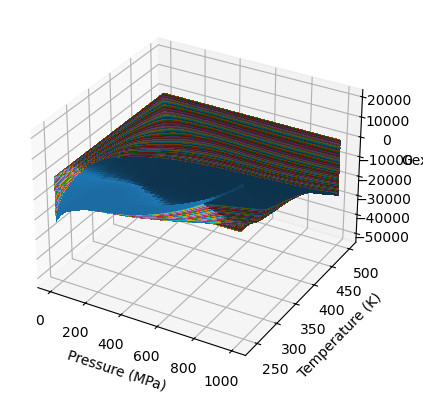

In [16]:
# define properties to iterate through
props = ('G', 'S', 'U', 'H', 'A', 'rho', 'Cp', 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'Gex')

# initialize lists to store summary statistics and correlation matricies for each property
variance = {}
min = {}
max = {}
mean = {}
correlation_matricies = {}

# define directory for G data  
dirG = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/MLGEO2024_NaCl_EoS/data/ai_ready/', 'G')
os.makedirs(dirG, exist_ok=True)
dfG = pq.read_table(os.path.join(dirG, 'NaCl_G.parquet')) 

# initialize dataframe with G data so I can iterate through the rest of the properties and add them to it
data_j = pd.concat([pd.DataFrame(dfG['P_Mpa']), pd.DataFrame(dfG['T_K']), pd.DataFrame(dfG['m_molkg'])], axis=1)


## Plot data in PT space for all properties with a surface for each concentration

In [ ]:
# iterate through properties
for j in props: 
    dir_ready = os.path.join('/Users/ulajones/Documents/School/ESS/ESS569F24/MLGEO2024_NaCl_EoS/data/ai_ready/', j)
    os.makedirs(dir_ready, exist_ok=True)
    df = pq.read_table(os.path.join(dir_ready, f'NaCl_{j}.parquet')) 
    
    # pull series for P, T, M from the dataframe 
    P =  pd.Series(df['P_Mpa']).unique()
    T =  pd.Series(df['T_K']).unique()
    C =  pd.Series(df['m_molkg']).unique()

    # convert m_molkg to list so I can filter by concentration 
    c1= df['m_molkg'].to_pandas()
    all_C = c1.tolist()

    # Create meshgrid for P and T
    P, T = np.meshgrid(P, T)

    tdv = df[f'{j}'].to_pandas()

    # Create 3D plot
    fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})

    for i in C:
        # Find indices where the concentration is equal to i
        indices = [index for index, value in enumerate(all_C) if value == i]
        
        # Filter tdv by the indices of each concentration
        tdv_filtered = tdv.iloc[indices]
    
        # Reshape tdv_filtered to be a P x T array
        tdv_reshaped = tdv_filtered.values.reshape(len(np.unique(T)), len(np.unique(P)))    
        
        # Plot each concentration surface
        surf = ax1.plot_surface(P, T, tdv_reshaped, label=f'Concentration {i}', linewidth=0, antialiased=False)
        ax1.set_xlabel('Pressure (MPa)')
        ax1.set_ylabel('Temperature (K)')
        ax1.set_zlabel(f'{j}')
    
    plt.show()

## Generate summary statistics

In [ ]:
for j in props: 
    # Generate summary statistics for each property
    variance[j] = np.var(tdv)
    min[j] = np.min(tdv)
    max[j] = np.max(tdv)
    mean[j] = np.mean(tdv)

    # Generate correlation matrix for each property
    correlation_matricies[j] = data_j.corr()
    
    # collect all tdvs in one file to look at correlations
    data_j[f'{j}'] = df[f'{j}']    

# define summary stats dataframe for all properties, concentrations
stats = {
'Variance': variance,
'Min': min,
'Max': max,
'Mean': mean
}  

stats_df = pd.DataFrame(stats)
stats_df.head()

data_j.columns = ['P_Mpa', 'T_K', 'm_molkg', 'G', 'S', 'U', 'H', 'A', 'rho', 'Cp', 'Kt', 'Kp', 'Ks', 'alpha', 'vel', 'mus', 'muw', 'Vm', 'Cpm', 'Cpa', 'Va', 'Vex', 'phi', 'aw', 'Gex']
data_j.head()

# save combined lists as parquet file 
data_j.to_parquet('NaCl_combined_lists.parquet', index=False)
print(stats_df)


## Make a heat map to show correlations between each property

           Variance           Min           Max          Mean
G      6.719718e+10 -3.339859e+05  8.759804e+05  3.280921e+05
S      5.230935e+05 -8.390915e+02  2.585223e+03  1.090614e+03
U      5.964234e+10 -1.488161e+05  9.745279e+05  3.806885e+05
H      1.055005e+11 -1.487139e+05  1.620074e+06  7.850309e+05
A      1.056038e+10 -3.340935e+05  8.089984e+04 -7.625038e+04
rho    9.172395e+03  8.288979e+02  1.437947e+03  1.204569e+03
Cp     6.283487e+04  2.808580e+03  5.300979e+03  3.356827e+03
Kt     3.628699e+06  8.623593e+02  1.089582e+04  5.750874e+03
Kp     4.740270e-01  2.626046e+00  1.060790e+01  6.178589e+00
Ks     4.320056e+06  1.252816e+03  1.127153e+04  6.394462e+03
alpha  1.269224e-08 -1.804429e-03  1.674734e-03  4.504977e-04
vel    1.024406e+05  1.155647e+03  2.803086e+03  2.262531e+03
mus    2.441839e+08 -1.073519e+05  4.200433e+04  7.499103e+03
muw    2.492266e+07 -6.776816e+03  1.578103e+04  6.324526e+03
Vm     4.231515e+00 -2.009510e+01  3.494676e+01  2.542482e+01
Cpm    2

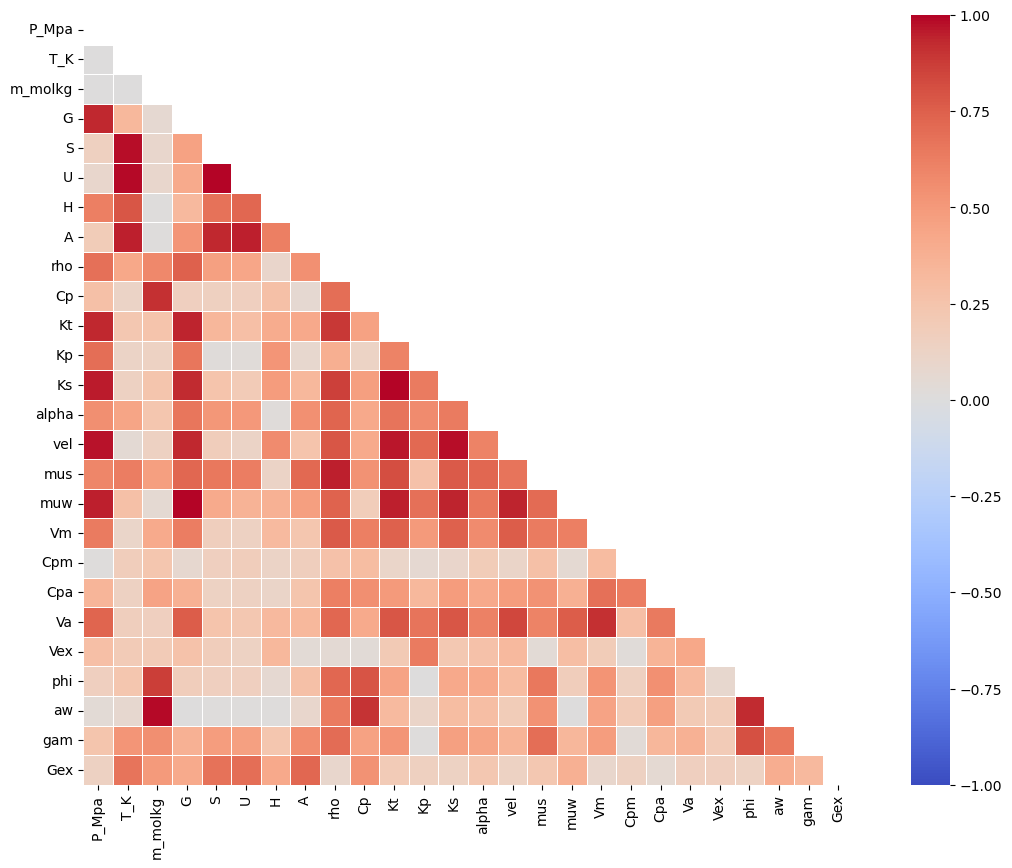

In [17]:
# Remove possible infinities from the data
data_j = data_j.replace([np.inf, -np.inf], np.nan, inplace= False)

# Compute pairwise correlation of columns
corr_matrix = data_j.corr().abs()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap with the mask
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, square=True, linewidths=.5, 
            #cbar_kws={"shrink": .5}, 
            annot= False)

plt.show()

data_j.to_parquet('NaCl_combined_lists.parquet', index=False)

It is not surprising to see strong correlations between entropy, temperature, and various internal energies (S = dQ/T, U = Q-W), as well as heat capacity and concentration. The strong pressure dependence of Gibbs energy is apparent in the corresponding surface plot, as are most such relations. Water activity (aw) and the osmotic coefficient (phi) are predictably very dependent on concentration. Chemical potentials are molar Gibbs energies, so we also expect these correlations to be high.

The variances are large, as this dataset spans a huge range of pressures, temperatures, and concentrations, but the mean values are still largely reasonable for seawater. G has a large variance of 6.72e+10, with values ranging from -333,985.9 to 875,980.4 and a mean of 328,092.1. Similarly, S has a variance of 523,093.5, with a minimum of -839.1, a maximum of 2,585.2, and a mean of 1,090.6. U and H also exhibit significant variances of 5.96e+10 and 1.06e+11, respectively. On the other hand, rho and Cp have lower variances of 9,172.4 and 62,834.9, so their values are generally more consistent. Some type of standardization will have to be applied to correct for this.

In light of these wide variances, I don't know that I will be able to train a model to replicate the complex behavior of this many derivatives, so I'll limit work to 'G', 'S', 'U', 'H', 'A', 'rho', and 'Cp' from now on.
 